In [1]:
import pandas as pd

pd.set_option('display.max_columns', None)

regis = pd.read_excel('Data/MTB Registrants (Spring 19 - Spring 24).xlsx')
clients = pd.read_excel('Data/All Clients.xlsx')
awards = pd.read_excel('Data/All Client Awards by Agency.xlsx')

regis = regis.merge(clients, on="Client ID", how="left")
regis = regis[['Client ID', 'Company Name_x', 'Company Primary Contact',
       'Registration Name', 'Phone_x', 'Email_x', 'MTB Date', 'Attended?',
       'Client', 'Primary Contact', 'Last Counseling',
       'Business Languages', 'Business Size', 'Business Type', 'Center',
       'Client/Pre-client Type', 'Company Veteran Status',
       'DBA', 'DIB Ready Date', 'Defense Industrial Base (DIB) ready?',
       'Disadvantage Certification Date', 'Disadvantage Status',
       'DoD Covered Small Business?', 'Full-Time Employees',
       'GIB-SL Ready Date', 'GIB-F Ready Date',
       'Gross Exported-Related Revenue', 'Gross Revenue', 'HUBZone',
       'HUBZone Certification Date', 'Industry', 'Initial Business Status',
       'Key Technology Areas', 'Key Technology Sub-areas',
       'Member of an underserved community?', 'Part-Time Employees',
       'Phone Number', 'Physical Address', 'Physical Address City',
       'Physical Address County', 'Physical Address State',
       'Physical Address ZIP Code', 'Primary Consultants', 'Primary NAICS',
       'Primary PSC', 'State of Incorporation',
       'State/Local Government Industrial Base (GIB-SL)?',
       'Subscribe to emails?', 'Unique Entity Identifier',
       'Veteran Certification Date']]

c:\Users\ADMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [2]:
def get_industries(df):
    if pd.notna(df['Primary NAICS']):
        df['industry_code'] = str(df['Primary NAICS'])[:2]
    else:
        df['industry_code'] = '00'
    return df

regis = regis.apply(get_industries, axis=1)

In [3]:
naics_to_industry = {
    '11': 'Agriculture, Forestry, Fishing and Hunting',
    '21': 'Mining, Quarrying, and Oil and Gas Extraction',
    '22': 'Utilities',
    '23': 'Construction',
    '31': 'Manufacturing (Food, Apparel, Wood Products, etc.)',
    '32': 'Manufacturing (Wood, Paper, Chemical, etc.)',
    '33': 'Manufacturing (Machinery, Computer, Electronics, etc.)',
    '42': 'Wholesale Trade',
    '44': 'Retail Trade',
    '45': 'Retail Trade (Other)',
    '48': 'Transportation and Warehousing',
    '49': 'Postal Service',
    '51': 'Information',
    '52': 'Finance and Insurance',
    '53': 'Real Estate and Rental and Leasing',
    '54': 'Professional, Scientific, and Technical Services',
    '55': 'Management of Companies and Enterprises',
    '56': 'Administrative and Support and Waste Management and Remediation Services',
    '61': 'Educational Services',
    '62': 'Health Care and Social Assistance',
    '71': 'Arts, Entertainment, and Recreation',
    '72': 'Accommodation and Food Services',
    '81': 'Other Services (except Public Administration)',
    '92': 'Public Administration', 
    '00': 'None'
}

regis['industry_name'] = regis['industry_code'].map(naics_to_industry)

In [4]:
import pandasql as pdsql

query = """
WITH total_count AS (
    SELECT SUM(COUNT(*)) OVER() AS total, industry_name, COUNT(*) AS count
    FROM regis
    WHERE industry_name != 'None'
    GROUP BY industry_name
)
SELECT industry_name, count, (count * 100.0 / total) AS percentage
FROM total_count
ORDER BY count DESC
"""

industry_pie = pdsql.sqldf(query, locals())

In [5]:
long_to_short_industry = {
    'Agriculture, Forestry, Fishing and Hunting': 'Agriculture',
    'Mining, Quarrying, and Oil and Gas Extraction': 'Mining',
    'Utilities': 'Utilities',
    'Construction': 'Construction',
    'Manufacturing (Food, Apparel, Wood Products, etc.)': 'Manufacturing',
    'Manufacturing (Wood, Paper, Chemical, etc.)': 'Manufacturing',
    'Manufacturing (Machinery, Computer, Electronics, etc.)': 'Manufacturing',
    'Wholesale Trade': 'Wholesale Trade',
    'Retail Trade': 'Retail Trade',
    'Retail Trade (Other)': 'Retail Trade (Other)',
    'Transportation and Warehousing': 'Transportation',
    'Postal Service': 'Postal Service',
    'Information': 'Information',
    'Finance and Insurance': 'Finance and Insurance',
    'Real Estate and Rental and Leasing': 'Real Estate',
    'Professional, Scientific, and Technical Services': 'Professional Services',
    'Management of Companies and Enterprises': 'Management of Companies',
    'Administrative and Support and Waste Management and Remediation Services': 'Admin and Waste Mgmt Services',
    'Educational Services': 'Educational Services',
    'Health Care and Social Assistance': 'Health Care',
    'Arts, Entertainment, and Recreation': 'Arts and Recreation',
    'Accommodation and Food Services': 'Accommodation and Food',
    'Other Services (except Public Administration)': 'Other Services',
    'Public Administration': 'Public Administration',
    'None': 'None'
}

industry_pie['industry_name'] = industry_pie['industry_name'].map(long_to_short_industry)
industry_pie.to_excel('Deliverables/MTB Fall24 Industry Distribution.xlsx', index=False)

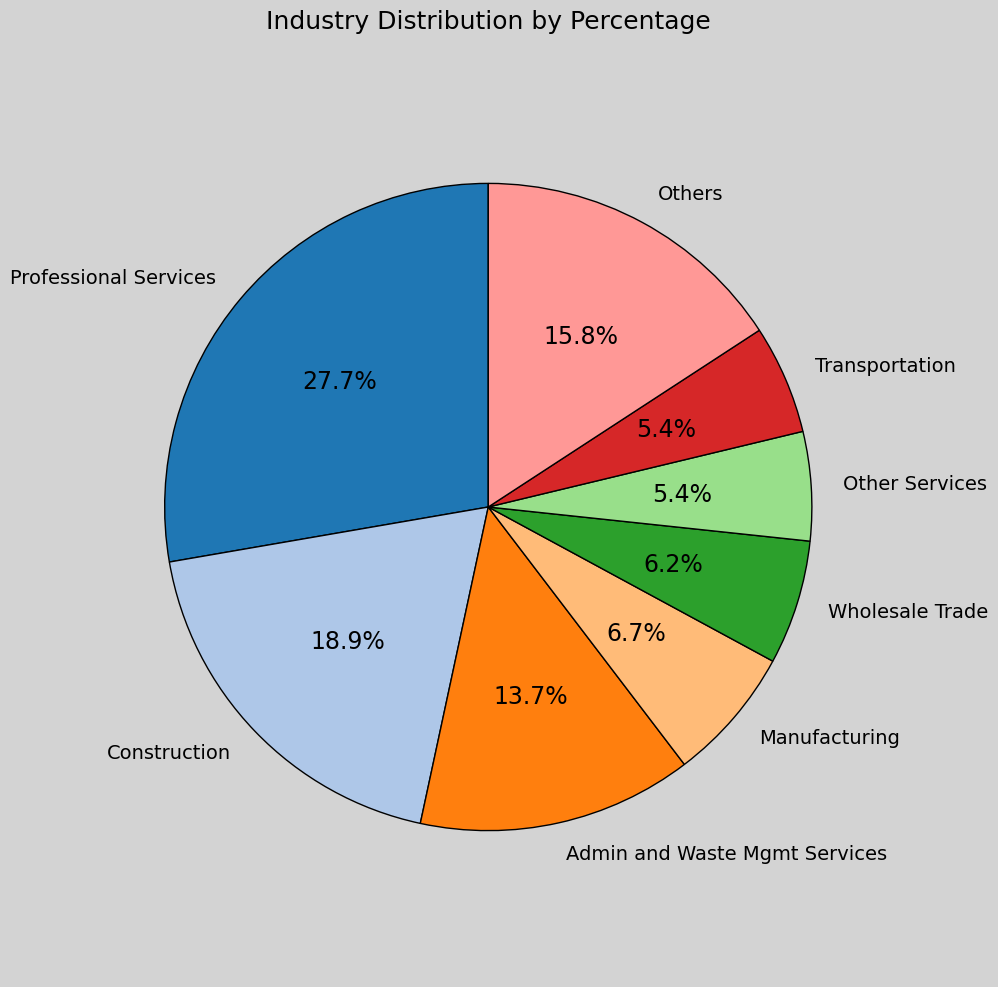

In [6]:
import matplotlib.pyplot as plt

industries = industry_pie['industry_name']
percentages = industry_pie['percentage']

industry_df = pd.DataFrame({'industry_name': industries, 'percentage': percentages})

main_industries = industry_df[industry_df['percentage'] >= 3]
small_industries = industry_df[industry_df['percentage'] < 3]
others_percentage = small_industries['percentage'].sum()
others_row = pd.DataFrame({'industry_name': ['Others'], 'percentage': [others_percentage]})

main_industries = pd.concat([main_industries, others_row], ignore_index=True)

colors = plt.get_cmap('tab20').colors

fig = plt.figure(figsize=(10, 10))

fig.set_facecolor('lightgray')

wedges, texts, autotexts = plt.pie(main_industries['percentage'], 
                                   labels=main_industries['industry_name'], 
                                   autopct='%1.1f%%', 
                                   startangle=90, 
                                   colors=colors[:len(main_industries)],
                                   wedgeprops={'edgecolor': 'black', 'linewidth': 1.0})

for text in texts:
    text.set_fontsize(14)
for autotext in autotexts:
    autotext.set_fontsize(17)
    autotext.set_color('black')  

plt.axis('equal')

plt.title('Industry Distribution by Percentage', fontsize=18)

plt.tight_layout() 

plt.savefig('Deliverables/MTB Fall24 Industry Distribution Pie Chart.png', bbox_inches='tight')
plt.show()

In [7]:
import numpy as np

missing_indices = regis['Company Name_x'].isnull()

for idx in regis[missing_indices].index:
    regis.at[idx, 'Company Name_x'] = f'unique_company_{idx}'

len(set(regis['Company Name_x']))

462

In [8]:
awardRegis = regis.merge(awards, on="Client ID", how="left")

In [14]:
regisAwarded = awardRegis.dropna(subset='Reporting Date')
regisAwarded.to_excel('Awarded Attendees.xlsx', index=False)

In [9]:
query="""
SELECT 
    "Agency Type", 
    SUM("Number of Contract Awards") AS numContracts, 
    SUM("Contract Amount") AS total, 
    SUM(DodAwardAmt) AS dodAmt,
    SUM(OtherFedAwardAmt) AS fedAmt, 
    SUM(StateAwardAmt) AS stateAmt, 
    SUM(CommAwardAmt) AS commAmt
FROM awardRegis
GROUP BY "Agency Type"
ORDER BY total
"""

agencyType = pdsql.sqldf(query, locals())
agencyType = agencyType.dropna(subset='numContracts')
agencyType

,Agency Type,numContracts,total,dodAmt,fedAmt,stateAmt,commAmt
1,I,1.0,7.142620e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.0
2,CO,1.0,3.000000e+07,0.000000e+00,0.000000e+00,0.000000e+00,30000000.0
3,S,2357.0,2.956525e+08,0.000000e+00,0.000000e+00,2.956525e+08,0.0
4,O,5229.0,7.081804e+08,0.000000e+00,7.081804e+08,0.000000e+00,0.0
5,D,32270.0,1.194369e+09,1.194369e+09,0.000000e+00,0.000000e+00,0.0


In [10]:
agency_mapping = {
    'I': 'International',
    'CO': 'Commercial',
    'S': 'State Agencies',
    'O': 'Other Federal Agencies',
    'D': 'Department of Defense'
}

agencyType['Agency Type'] = agencyType['Agency Type'].replace(agency_mapping)

agencyType

,Agency Type,numContracts,total,dodAmt,fedAmt,stateAmt,commAmt
1,International,1.0,7.142620e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.0
2,Commercial,1.0,3.000000e+07,0.000000e+00,0.000000e+00,0.000000e+00,30000000.0
3,State Agencies,2357.0,2.956525e+08,0.000000e+00,0.000000e+00,2.956525e+08,0.0
4,Other Federal Agencies,5229.0,7.081804e+08,0.000000e+00,7.081804e+08,0.000000e+00,0.0
5,Department of Defense,32270.0,1.194369e+09,1.194369e+09,0.000000e+00,0.000000e+00,0.0


In [15]:
total_awards = agencyType['total'].sum()

print(f'Dollar about attendees won: {total_awards:,.2f}')
print(f'Total countracts attendees won: {agencyType['numContracts'].sum():,.0f}')

Dollar about attendees won: 2,228,208,573.53
Total countracts attendees won: 39,858


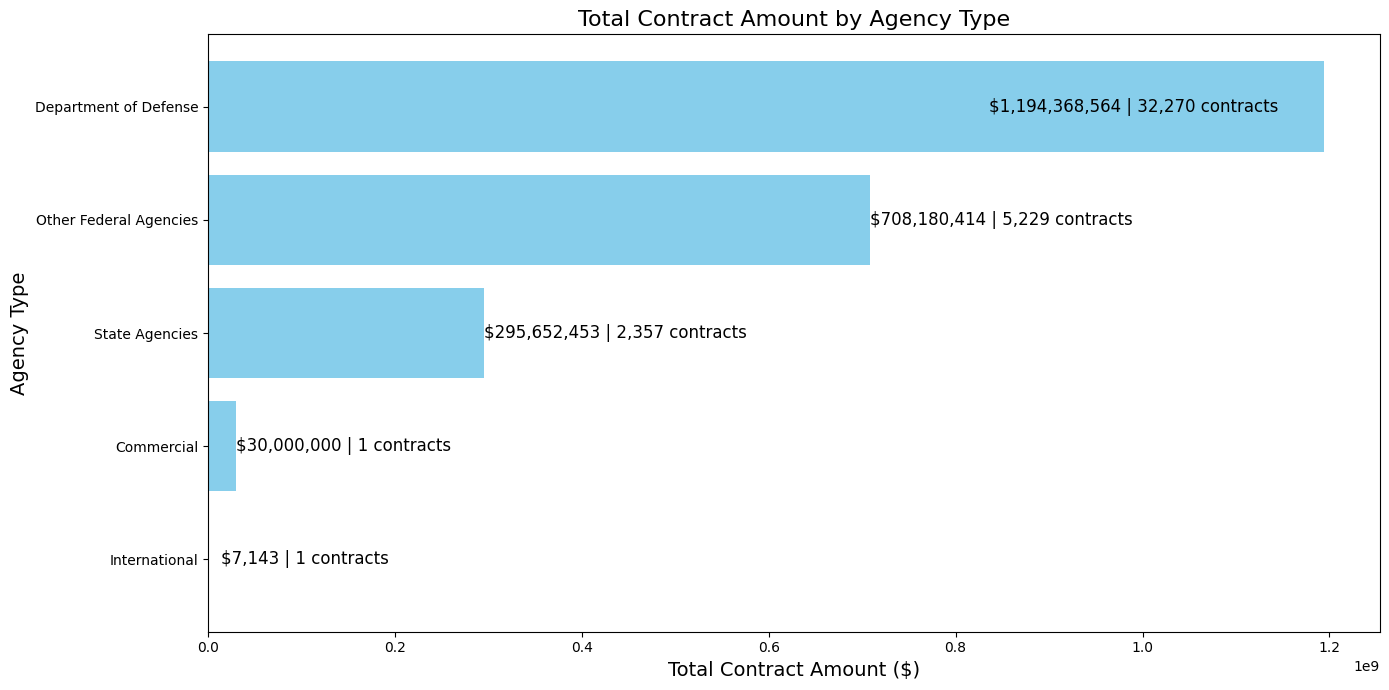

In [12]:
plt.figure(figsize=(14, 7))

bars = plt.barh(agencyType['Agency Type'], agencyType['total'], color='skyblue')

for index, bar in enumerate(bars):
    total_value = agencyType['total'].iloc[index]
    num_contracts = agencyType['numContracts'].iloc[index]
    
    if index == 4:
        plt.text(total_value * 0.7, bar.get_y() + bar.get_height()/2,
                 f'${total_value:,.0f} | {num_contracts:,.0f} contracts',
                 va='center', ha='left', fontsize=12)
    elif index == 0:
        plt.text(total_value * 2e3, bar.get_y() + bar.get_height()/2, 
                 f'${total_value:,.0f} | {num_contracts:,.0f} contracts',
                 va='center', ha='left', fontsize=12)
    else:
        plt.text(total_value, bar.get_y() + bar.get_height()/2,
                 f'${total_value:,.0f} | {num_contracts:,.0f} contracts',
                 va='center', ha='left', fontsize=12)

plt.xlabel('Total Contract Amount ($)', fontsize=14)
plt.ylabel('Agency Type', fontsize=14)
plt.title('Total Contract Amount by Agency Type', fontsize=16)

plt.tight_layout()

plt.savefig('Deliverables/Attendees Contracts By Agency.png', bbox_inches='tight')

plt.show()